# Probability Basics and Linear Classification


## First Example (Two Moons)

Let us start by loading a very simple toy dataset, the "two moons".

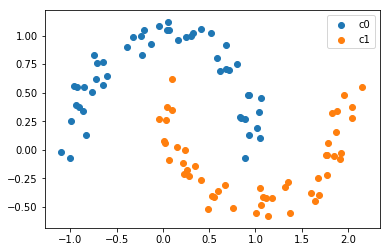

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Callable

data = dict(np.load("two_moons.npz", allow_pickle=True))
samples = data["samples"]
labels = data["labels"]

c0_samples = samples[labels == 0]
c1_samples = samples[labels == 1]

plt.figure("Data")
plt.scatter(x=c0_samples[:, 0], y=c0_samples[:, 1])
plt.scatter(x=c1_samples[:, 0], y=c1_samples[:, 1])
plt.legend(["c0", "c1"])

Let us also define some plotting utility

In [2]:
def draw_2d_gaussian(mu: np.ndarray, sigma: np.ndarray, plt_std: float = 2, *args, **kwargs) -> None:
    (largest_eigval, smallest_eigval), eigvec = np.linalg.eig(sigma)
    phi = -np.arctan2(eigvec[0, 1], eigvec[0, 0])

    plt.scatter(mu[0:1], mu[1:2], marker="x", *args, **kwargs)

    a = plt_std * np.sqrt(largest_eigval)
    b = plt_std * np.sqrt(smallest_eigval)

    ellipse_x_r = a * np.cos(np.linspace(0, 2 * np.pi, num=200))
    ellipse_y_r = b * np.sin(np.linspace(0, 2 * np.pi, num=200))

    R = np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
    r_ellipse = np.array([ellipse_x_r, ellipse_y_r]).T @ R
    plt.plot(mu[0] + r_ellipse[:, 0], mu[1] + r_ellipse[:, 1], *args, **kwargs)

# plot grid for contour plots
plt_range = np.arange(-1.5, 2.5, 0.01)
plt_grid = np.stack(np.meshgrid(plt_range, plt_range), axis=-1)
flat_plt_grid = np.reshape(plt_grid, [-1, 2])
plt_grid_shape = plt_grid.shape[:2]

### Discriminative Classifier using Logistic Regression

We start by implementing a few helper functions for affine mappings, the sigmoid function and the negative bernoulli log-likelihood.

In [3]:
def affine_features(x: np.ndarray) -> np.ndarray:
    """
    implements affine feature function
    :param x: inputs, shape: [N x sample_dim]
    :return inputs with additional bias dimension, shape: [N x feature_dim]
    """
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=-1)

def quad_features(x: np.ndarray) -> np.ndarray:
    """
    implements quadratic feature function
    :param x: inputs, shape: [N x sample_dim]
    :return squared features of x, shape: [N x feature_dim]
    """
    sq = np.stack([x[:, 0] ** 2, x[:, 1]**2, x[:, 0] * x[:, 1]], axis=-1)
    return np.concatenate([sq, affine_features(x)], axis=-1)

def cubic_features(x: np.ndarray) -> np.ndarray:
    """
    implements cubic feature function
    :param x: inputs, shape: [N x sample_dim]
    :return cubic features of x, shape: [N x feature_dim]
    """
    cubic = np.stack([x[:, 0]**3, x[:, 0]**2 * x[:, 1], x[:, 0] * x[:, 1]**2, x[:, 1]**3], axis=-1)
    return np.concatenate([cubic, quad_features(x)], axis=-1)

def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    the sigmoid function
    :param x: inputs 
    :return sigma(x)
    """
    return 1 / (1 + np.exp(-x))

def bernoulli_nll(predictions: np.ndarray, labels: np.ndarray, epsilon: float = 1e-12) -> np.ndarray:
    """
    :param predictions: output of the classifier, shape: [N]
    :param labels: true labels of the samples, shape: [N]
    :param epsilon: small offset to avoid numerical instabilities (i.e log(0))
    :return negative log-likelihood of the labels given the predictions
    """
    return - (labels * np.log(predictions + epsilon) + (1 - labels) * np.log(1 - predictions + epsilon))


### Optimization by Gradient Descent


First, we implement a very simple gradient descent optimizer. It iterativly applies the gradient descent rule
introduced in the lecture
$$ \boldsymbol{x}_{t+1} = \boldsymbol{x}_t - \eta \nabla f(\boldsymbol{x}_t).$$

We also add some simple stopping criteria which terminate the minimization if the algorithm has converged.

In [4]:
def minimize(f: Callable , df: Callable, x0: np.ndarray, lr: float, num_iters: int) -> \
        Tuple[np.ndarray, float, np.ndarray, np.ndarray]:
    """
    :param f: objective function
    :param df: gradient of objective function
    :param x0: start point, shape [dimension]
    :param lr: learning rate
    :param num_iters: maximum number of iterations
    :return argmin, min, values of x for all interations, value of f(x) for all iterations
    """
    # initialize
    x = np.zeros([num_iters + 1] + list(x0.shape))
    f_x = np.zeros(num_iters + 1)
    x[0] = x0
    f_x[0] = f(x0)
    for i in range(num_iters):
        # update using gradient descent rule
        grad = df(x[i])
        x[i + 1] = x[i] - lr * grad
        f_x[i + 1] = f(x[i + 1])
    return x[i+1], f_x[i+1], x[:i+1], f_x[:i+1] # logging info for visualization


**Practical Aspect:** While such a simple gradient descent optimizer works for the task we are considering and is simple enough to implement, in practice you should always use more sophisticated optimizers (e.g. L-BFGS) and use existing implementations. Such efficient and well-tested implementations are provided by software packages such as NlOpt or scipy.optimize.

Next, we need to define the cost function and its derivative. Maximizing the likelihood is equivalent to minimizing the negative log-likelihood, which we are using here. The derivation of the gradient is given in the lecture.

Note that we do not sum the losses as in the lecutre but take the mean. This is just a multiplication with a constant, thus the optimal parameters do not change. Yet, working with the mean makes the loss, and more importantly, the length of the gradient independent of the number of samples.

In [5]:
def objective_bern(weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> float:
    """
    bernoulli log-likelihood objective 
    :param weights: current weights to evaluate, shape: [feature_dim]
    :param features: train samples, shape: [N x feature_dim]
    :param labels: class labels corresponding to train samples, shape: [N]
    :return average negative log-likelihood 
    """
    predictions = sigmoid(features @ weights)
    return np.mean(bernoulli_nll(predictions, labels))

def d_objective_bern(weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    gradient of the bernoulli log-likelihood objective
    :param weights: current weights to evaluate, shape: [feature_dim]
    :param features: train samples, shape: [N x feature_dim]
    :param labels: class labels corresponding to train samples, shape [N]
    """
    res = np.expand_dims(sigmoid(features @ weights) - labels, -1)
    grad = features.T @ res / res.shape[0]
    return np.squeeze(grad)

Finally, we can tie everything together and get our probabilistic classifier

Final loss: 0.019875249179541393


(-1.5, 2.5)

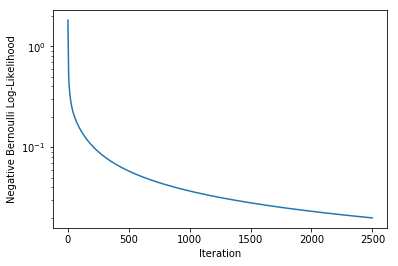

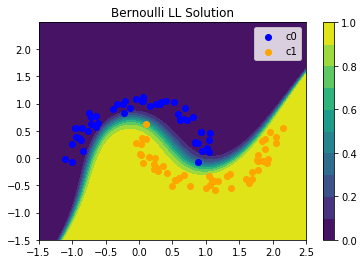

In [6]:
# Generate Features from Data

# change this to play arround with feature functions
#feature_fn = affine_features
#feature_fn = quad_features
feature_fn = cubic_features
features = feature_fn(samples)

# Optimize Loss
w_bce, loss, x_history, f_x_history = \
    minimize(lambda w: objective_bern(w, features, labels),
             lambda w: d_objective_bern(w, features, labels),
             np.ones(features.shape[1]), 1, 2500)

print("Final loss:", loss)
# Plot
plt.figure()
plt.semilogy(f_x_history)
plt.xlabel("Iteration")
plt.ylabel("Negative Bernoulli Log-Likelihood")

plt.figure()
plt.title("Bernoulli LL Solution")
pred_grid = np.reshape(sigmoid(feature_fn(flat_plt_grid) @ w_bce), plt_grid_shape)

plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)
plt.colorbar()

s0 = plt.scatter(c0_samples[..., 0], c0_samples[..., 1], color="blue")
s1 = plt.scatter(c1_samples[..., 0], c1_samples[..., 1], color="orange")
plt.legend([s0, s1], ["c0", "c1"])
#decision boundary: to get the right decision boundary we need to evaluate at sigma^-1(0.5) = 0.0
#plt.plot(np.array([-1.5, 2.5]), np.array([get_y(0.0, w_bce, -1.5), get_y(0.0, w_bce, 2.5)]), c="black")
plt.xlim(-1.5, 2.5)